In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from tqdm import tqdm
import time

from model.Model import make_dummy_model, MyModel
from model.augmentations import RandomHorizontalFlip, RandomMirror, RandomZoom, RandomRotate, RandomShift, OverlayBox, AddNoise, GaussianBlur, Ada, build_augmenter
from model.config import *
from model.callbacks import create_callbacks 
from model.metrics import dice_coef, dice_loss
from tools.utils import display_imgs, visualize_outputs
from tools.setup import get_data, setup_model, set_up_to_train
from tools.data_prep import get_data_df, data_generator, get_train_val, data_generator_tfrecordFile


# Setup Functions

In [3]:
ds_train, ds_val = get_data(args, from_tfRecords=True, train_tfrecord_file = train_tfrecord_file, val_tfrecord_file = None, aug_functions=aug_functions)

In [4]:
mmmm = iter(ds_train)

In [5]:
start = time.time()
test_imgs = next(mmmm)
end = time.time()
print('Duration:', end - start)

Duration: 0.6089856624603271


In [6]:
def make_dummy_model(img_size):

    if len(img_size) == 2:
        shape = (img_size[0], img_size[1], 3)
    if len(img_size) == 3:
        shape = img_size
    
    inputs = tf.keras.Input(shape=shape)
    x = layers.Conv2D(32, kernel_size=3, strides=1, padding="same", name='Conv1')(inputs)
    x = layers.BatchNormalization(name='BN')(x)
    x = layers.Activation("relu", name='Act')(x)
    outputs = layers.Conv2D(filters=1, kernel_size=3, activation="sigmoid", padding="same", name='Conv2')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [7]:
augment_func, temp_model = setup_model(args, aug_functions)

In [8]:
optimizer, augmentation_probability_tracker, dice_coeff_tracker, loss_tracker, val_dice_coeff_tracker, val_loss_tracker = set_up_to_train(args, config_opt, config_metrics, config_val_metrics)

# Confirm Stuff Works

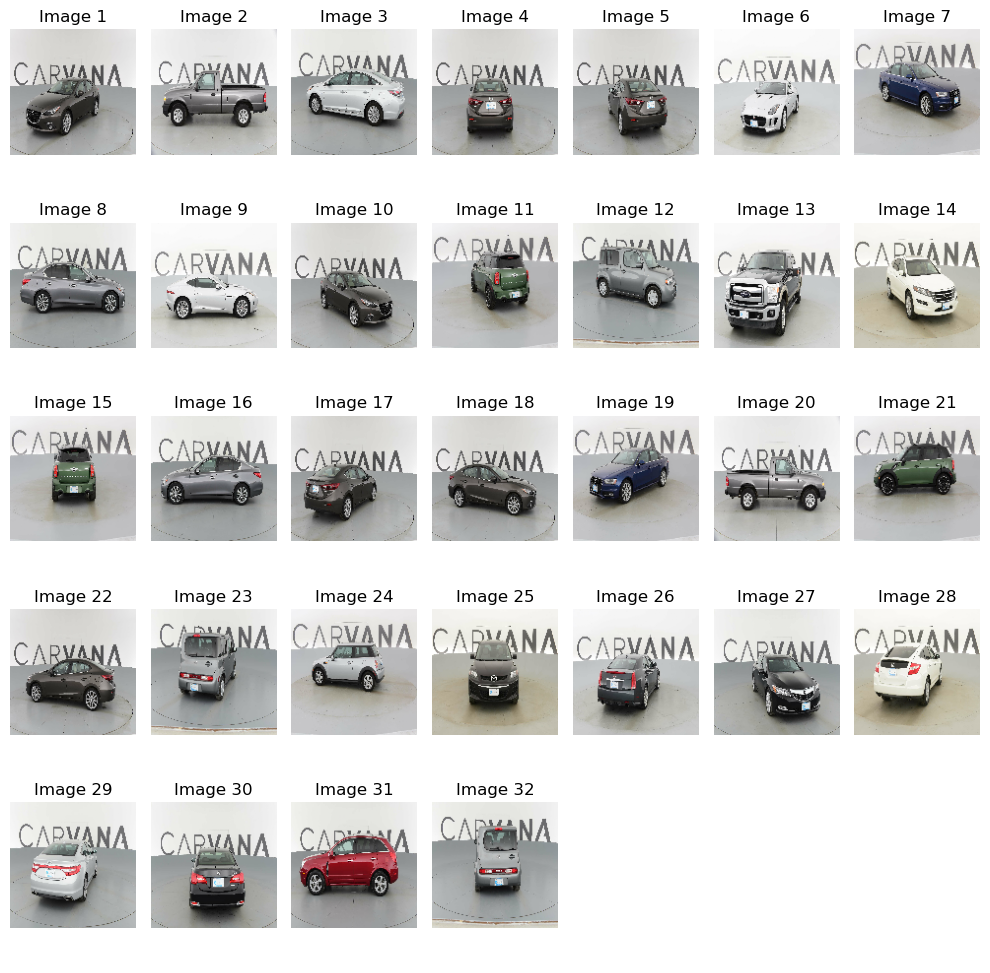

In [9]:
visualize_outputs(data=test_imgs, figsize=(10,10), save_to=r'D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation\code\images\data.jpg')

In [10]:
test_augment_funcs = build_augmenter(aug_functions, args.img_size)

In [11]:
out_aug_imgs = test_augment_funcs((test_imgs[0], test_imgs[1], tf.constant([0.05])))

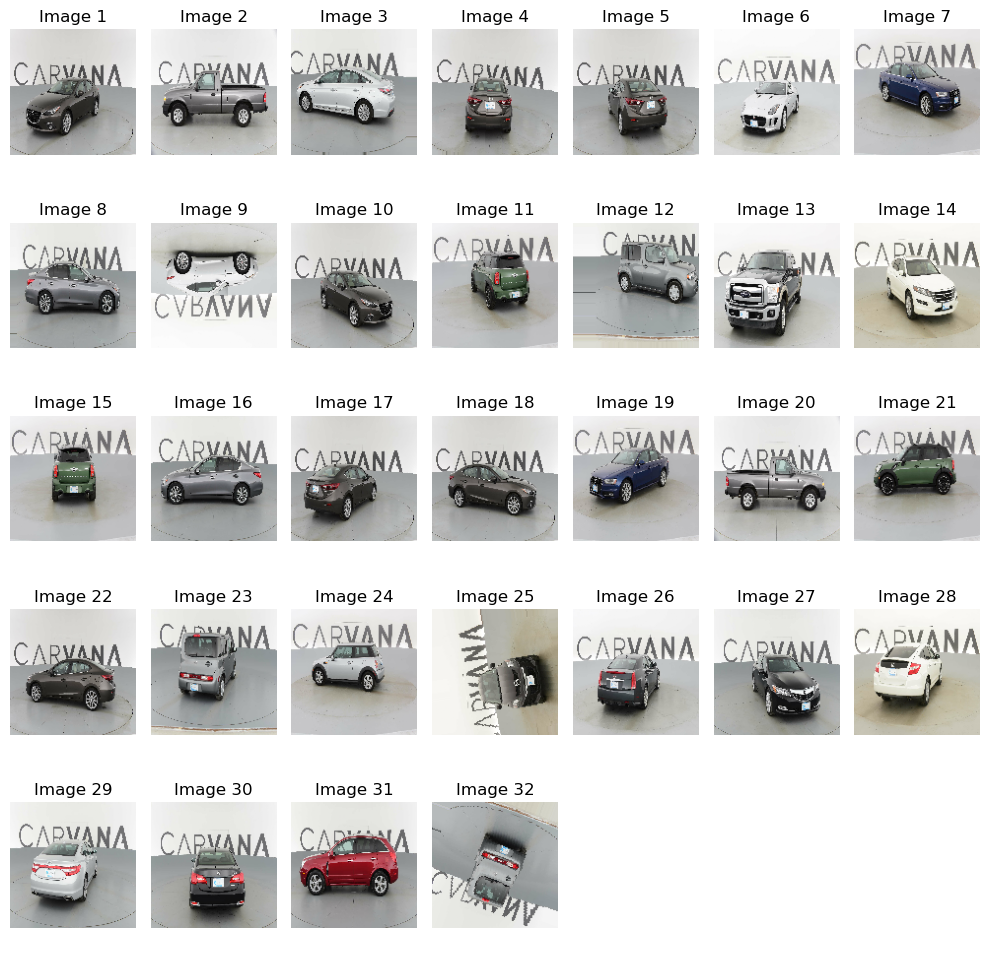

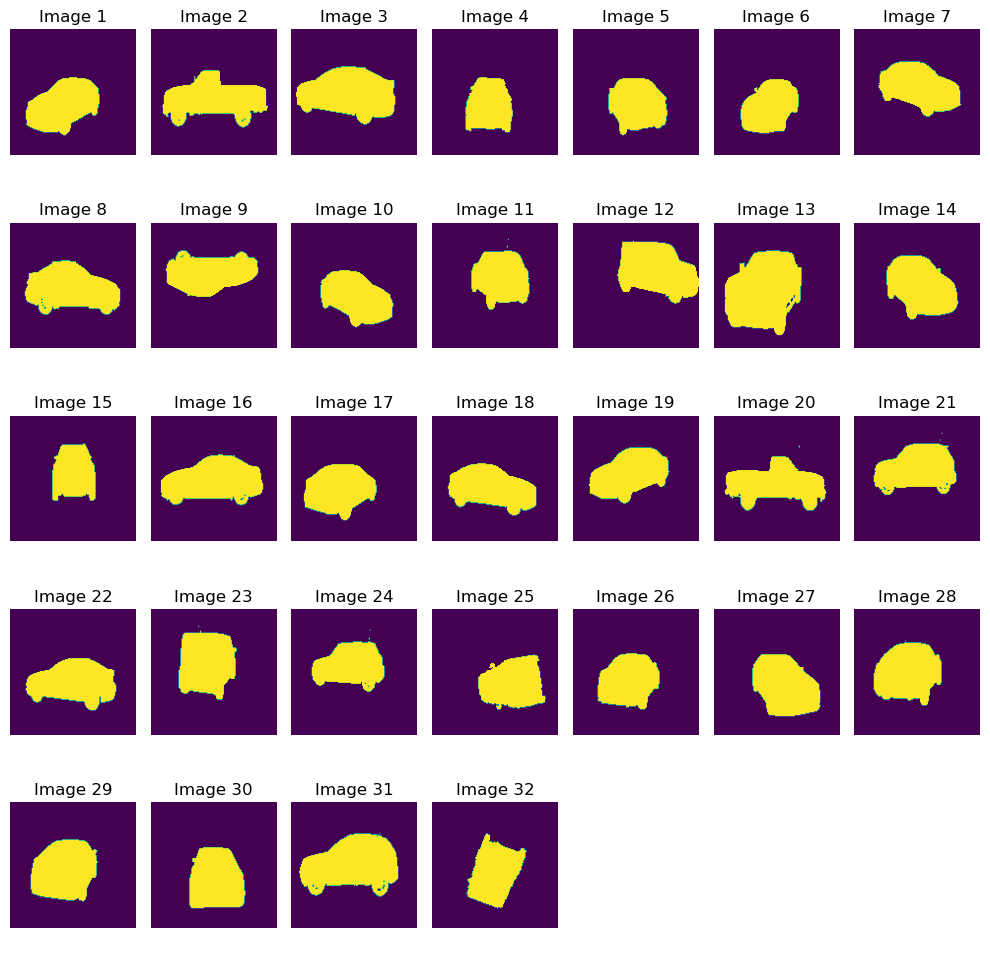

In [12]:
visualize_outputs(data=out_aug_imgs, figsize=(10,10))
visualize_outputs(data=[out_aug_imgs[1], out_aug_imgs[0]], figsize=(10,10))

In [13]:
test_ada = Ada(args.img_size, aug_functions=aug_functions, switch=True)

In [31]:
test_ada.update(tf.constant(0.1))
test_ada.probability

<tf.Variable 'ada_p:0' shape=(1, 1) dtype=float32, numpy=array([[0.8474199]], dtype=float32)>

In [32]:
test_ada_out = test_ada(test_imgs, training=True)

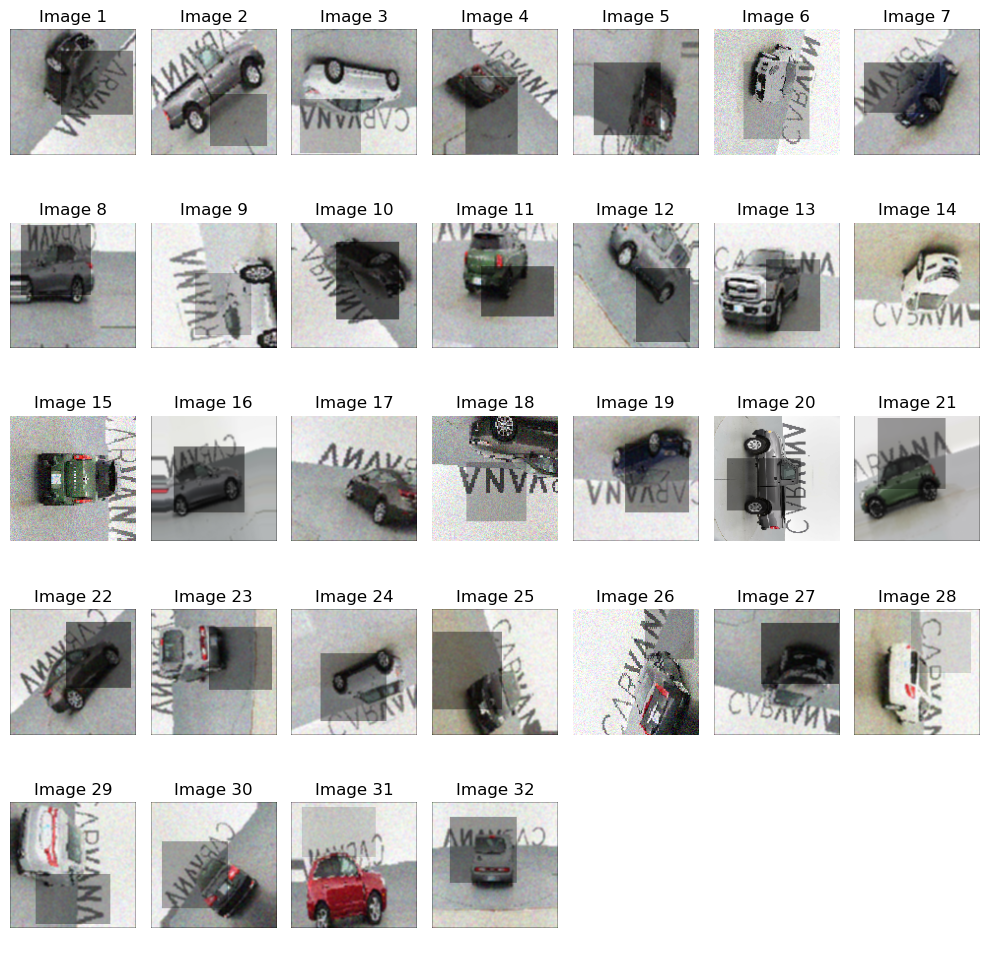

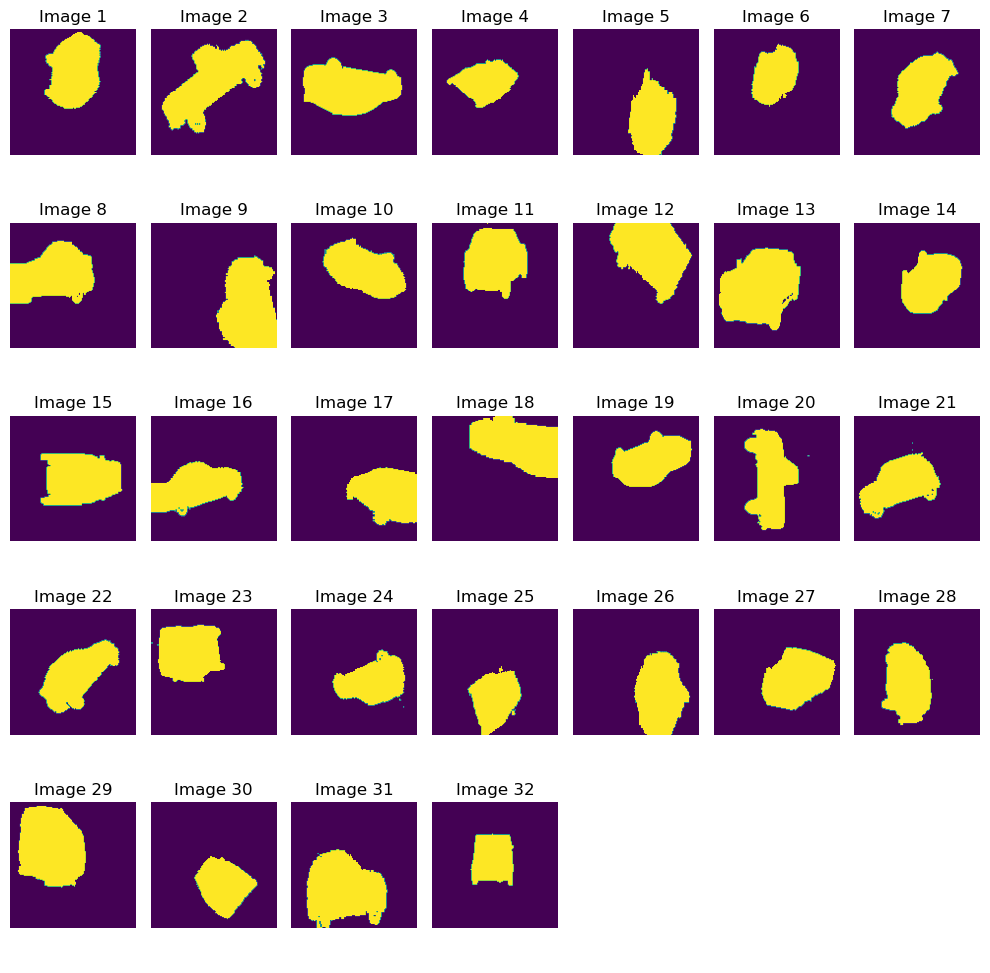

In [34]:
visualize_outputs(data=test_ada_out, figsize=(10,10)) #, save_to=r'D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation\code\images\data_ada_low_error.jpg'
visualize_outputs(data=[test_ada_out[1], test_ada_out[0]], figsize=(10,10)) #, save_to=r'D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation\code\images\mask_ada_low_error.jpg'

# Train

In [13]:
callbacks_list = create_callbacks(save_filepath, args, temp_model, img_path)
if args.training_method == 'eagerly':
    callbacks = tf.keras.callbacks.CallbackList(callbacks_list, add_history=True, model=temp_model)

In [15]:
@tf.function
def train_step(imgs, labels):

    imgs, labels = augment_func((imgs, labels), training=True)

    with tf.GradientTape() as tape:
        predicted = temp_model(imgs, training=True)
        loss_value = dice_loss(labels, predicted)
        
    grads = tape.gradient(loss_value, temp_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, temp_model.trainable_weights))

    augment_func.update(loss_value)
    loss_tracker.update_state(loss_value)
    dice_coeff_tracker.update_state(1-loss_value)
    augmentation_probability_tracker.update_state(augment_func.probability)
    return loss_value

@tf.function
def test_step(imgs, labels):

    val_predicted = temp_model(imgs, training=False)
    loss_value = dice_loss(labels, val_predicted)

    val_loss_tracker.update_state(loss_value)
    val_dice_coeff_tracker.update_state(1-loss_value)

  0%|          | 0/87 [00:00<?, ? Batches/s]

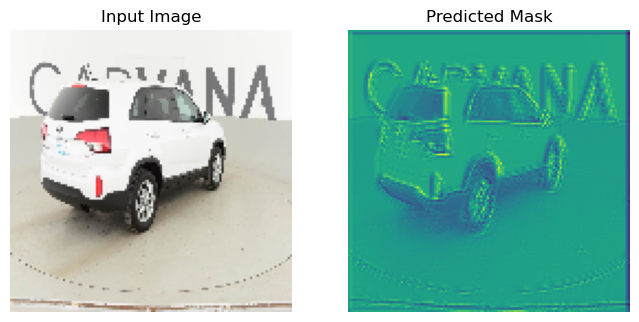

Epoch: 1: 100%|██████████| 87/87 [00:28<00:00,  3.05 Batches/s, augmentation_probability=0.0418, dice_coefficient=0.138, loss=0.862] 



Epoch 1: loss_metric improved from inf to 0.8618611097335815, saving model to D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation\Instance Segmentation\saved_model\temp_model.h5
Validation: Epoch - 0 val_dice_coeff - 0.16657595336437225 - val_loss - 0.8334240913391113


Epoch: 2: 100%|██████████| 87/87 [00:22<00:00,  3.88 Batches/s, augmentation_probability=0.0501, dice_coefficient=0.184, loss=0.816]



Epoch 2: loss_metric improved from 0.8618611097335815 to 0.816098690032959, saving model to D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation\Instance Segmentation\saved_model\temp_model.h5
Validation: Epoch - 1 val_dice_coeff - 0.17370286583900452 - val_loss - 0.8262970447540283


  0%|          | 0/87 [00:00<?, ? Batches/s]

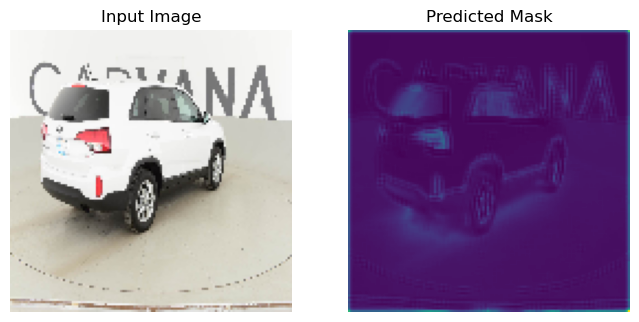

Epoch: 3: 100%|██████████| 87/87 [00:23<00:00,  3.78 Batches/s, augmentation_probability=0.0533, dice_coefficient=0.187, loss=0.813]



Epoch 3: loss_metric improved from 0.816098690032959 to 0.8132091164588928, saving model to D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation\Instance Segmentation\saved_model\temp_model.h5
Validation: Epoch - 2 val_dice_coeff - 0.1821857988834381 - val_loss - 0.8178143501281738


In [16]:
if args.training_method == 'eagerly':

    test_img_for_epoch_viz = img_to_array(load_img(img_path, target_size=args.img_size)) / 255
    temp_model.compile(optimizer=optimizer, loss=dice_loss, metrics=[loss_tracker])

    # Callback on train begin
    callbacks.on_train_begin()

    # Training Loop
    for epoch in range(args.epochs):

        with tqdm(enumerate(ds_train), unit=' Batches', total=len(ds_train)) as tepoch:

            # Callback on epoch begin
            callbacks.on_epoch_begin(epoch)

            for batch, (images, labels) in tepoch:

                # Set description and get loss value
                tepoch.set_description(f"Epoch: {epoch+1}")
                loss_value = train_step(images, labels)        

                # Display results after each batch
                train_loss = loss_tracker.result()
                train_acc = dice_coeff_tracker.result()
                aug_p = augmentation_probability_tracker.result()
                tepoch.set_postfix(loss=train_loss.numpy(), dice_coefficient=train_acc.numpy(), augmentation_probability=aug_p.numpy())

            # Callback on epoch end
            logs = {args.monitor: train_loss}
            callbacks.on_epoch_end(epoch, logs)

        # Reset metrics at the end of each epoch
        dice_coeff_tracker.reset_states()
        loss_tracker.reset_states()
        
        for batch, (images, labels) in enumerate(ds_val):

            test_step(images, labels)

        # Display results after each epoch
        val_acc = val_dice_coeff_tracker.result()
        val_loss = val_loss_tracker.result()
        print("Validation: Epoch - {} val_dice_coeff - {} - val_loss - {}".format(epoch, val_acc, val_loss))
        
        # Reset metrics at the end of each epoch
        val_dice_coeff_tracker.reset_states()
        val_loss_tracker.reset_states()

    # Callback on train end
    callbacks.on_train_end()
else:

    temp_model.compile(optimizer=optimizer, loss=dice_loss, metrics=[loss_tracker])
    temp_model.fit(ds_train, epochs=args.epochs, callbacks=callbacks_list)

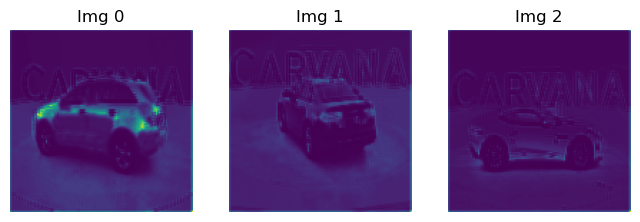

In [19]:
display_imgs(*temp_model(test_imgs[0], training=False)[0:3]) # test_imgs[0], training=True | test_imgs, training=True, augment=True

# TFRecords

In [76]:
from utils import save_images_to_tfrecord, read_tfrecord

In [77]:
output_file = r"D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation\TFRecordFiles\train.tfrecord"
train_path = r'D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation\train\train'
mask_path = r'D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation\train_masks\train_masks'
# save_images_to_tfrecord(train_path, mask_path, output_file)

In [78]:
tfrecord_file = 'D:\\DL-CV-ML Projects\\Carvana Challenge - Instance Segmentation\\TFRecordFiles\\train.tfrecord'
features = read_tfrecord(tfrecord_file)

In [79]:
features

{'image/encoded': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 'image/width': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'image/height': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'image/filename': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 'mask/encoded': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 'mask/width': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'mask/height': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'mask/filename': FixedLenFeature(shape=[], dtype=tf.string, default_value=None)}